<h1 style="margin-bottom: 3px;">
  <hr style="border:none; height:3px;">
  <center>PFITZER PROJECT</center>
  <hr style="border:none; height:3px;">
</h1>

<h2 style="text-align:center; margin-top: 3px;">Assigning Sales Representatives to a Territory</h2>

<p><center><strong>Group 19:</strong> Abderrahmane DKOUR, Malek BOUHADIDA, Yuxian ZUO</center></p>


# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from gurobipy import Model, GRB, quicksum

from load import load_data_22_4, load_data_100_10
from utils import *

# Table of Contents
- [Step1](#Step1)
- [Step2](#Step2)
- [Step3](#Step3)
- [Step4](#Step4)

# Step1
First, we load the data provided.

In [2]:
distances, workloads, current_assignment, bricks_distances = load_data_22_4()

## Two Mono-Objective Linear Optimization Models
The easiest approch to start with is by formulating **two mono-objective linear optimization models**, one for the distance objective and one for the disruption objective.

**Models:**

1. **Distance Minimization**: Minimize the total travel distance for Sales Representatives (SRs).
2. **Disruption Minimization**: Minimize disruption by assigning bricks as close as possible to their current SR assignments.

**Parameters:**

Let:

- $I = \{1, 2, \dots, 22\}$: Set of bricks.  
- $J = \{1, 2, 3, 4\}$: Set of Sales Representatives (SRs).  
- $d_{ij}$: Distance between SR $j$'s center brick and brick $i$.  
- $w_i$: Workload index value of brick $i$.  
- $x_{ij}$: Binary decision variable (1 if brick $i$ is assigned to SR $j$, 0 otherwise).  
- $c_{ij}$: Binary parameter (1 if brick $i$ is currently assigned to SR $j$, 0 otherwise).  

**Objectives:**

Distance Minimization:
$$
Z_1 = \min \sum_{i \in I} \sum_{j \in J} d_{ij} \cdot x_{ij}
$$

Disruption Minimization:
$$
Z_2 = \min \sum_{i \in I} \sum_{j \in J} w_i \cdot |x_{ij} - c_{ij}|
$$

where $|x_{ij} - c_{ij}|$ accounts for reassignment.

**Constraints:**

1. Each brick is assigned to exactly one SR:  
$$
\sum_{j \in J} x_{ij} = 1, \quad \forall i \in I
$$

2. Workload constraints: e.g., the workload for each SR must be balanced between 0.8 and 1.2:  
$$
0.8 \leqslant \sum_{i \in I} w_i \cdot x_{ij} \leqslant 1.2, \quad \forall j \in J
$$

### Distance Minimization Model

We can start by implementing and solving the distance minimization problem for an instance with 22 bricks and 4 SRs. We choose [0.8 , 1.2] as the accepted workload interval.

In [3]:
bricks = range(22)
SRs = range(4)

In [4]:
def mono_objective_distance(workload_min, workload_max, workloads, distances, bricks, SRs):

    model = Model("Distance Minimization")
    # Variables
    x = model.addVars(22, 4, vtype=GRB.BINARY, name="x")

    # Objective Function
    model.setObjective(quicksum(distances[i][j] * x[i, j] 
                                        for i in bricks for j in SRs), GRB.MINIMIZE)

    # Constraints
    # Each brick is assigned 100%
    for i in bricks:
        model.addConstr(quicksum(x[i, j] for j in SRs) == 1)
    # Workload constraints for each SR
    for j in SRs:
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) >= workload_min)
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) <= workload_max)

    # Optimization
    model.optimize()
    
    return model, x

In [ ]:
model_dist, x_dist = mono_objective_distance(workload_min=0.8,
                                            workload_max=1.2, 
                                            workloads=workloads, 
                                            distances=distances, 
                                            bricks=bricks, 
                                            SRs=SRs)

In [6]:
print_new_assignment(model=model_dist, x=x_dist, SRs=SRs, bricks=bricks)

Optimal Value: 154.59999999999997
SR 1 was assigned bricks: [4, 5, 6, 7, 8, 9, 12, 19, 20]
SR 2 was assigned bricks: [11, 13, 14, 18]
SR 3 was assigned bricks: [10, 15, 16, 17]
SR 4 was assigned bricks: [1, 2, 3, 21, 22]


### Disruption Minimization Model

We now move to the resolution of the disruption minimization problem. We use the same instance and the same workload interval.

In [7]:
def mono_objective_disruption(workload_min, workload_max, workloads, current_assignment, bricks, SRs):

    model = Model("Disruption Minimization")

    # Variables
    x = model.addVars(22, 4, vtype=GRB.BINARY, name="x")

    # Objective Function
    model.setObjective(
        quicksum(workloads[i] * (x[i, j] - 2*current_assignment[i, j]*x[i, j] + current_assignment[i, j])
                 for i in bricks for j in SRs), GRB.MINIMIZE)

    # Constraints
    # Each brick is assigned 100%
    for i in bricks:
        model.addConstr(quicksum(x[i, j] for j in SRs) == 1)
    # Workload constraints for each SR
    for j in SRs:
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) >= workload_min)
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) <= workload_max)

    # Optimization
    model.optimize()
    
    return model, x

In [ ]:
model_disrup, x_disrup = mono_objective_disruption(workload_min=0.8, 
                                                workload_max=1.2, 
                                                workloads=workloads, 
                                                current_assignment=current_assignment, 
                                                bricks=bricks, 
                                                SRs=SRs)

In [9]:
print_new_assignment(model=model_disrup, x=x_disrup, SRs=SRs, bricks=bricks)

Optimal Value: 1.0202
SR 1 was assigned bricks: [1, 2, 3, 4, 5, 11, 20]
SR 2 was assigned bricks: [6, 7, 8, 9, 12, 17, 21]
SR 3 was assigned bricks: [10, 13, 14]
SR 4 was assigned bricks: [15, 16, 18, 19, 22]


## Epsilon-Constraint Minimization Model

Instead of minimizating the distance and disruption objectives seperately, we can use the epsilon-constraint scheme to minimize them at the same time.

For that we choose the distance as the main objective, and the disruption as a constraint, below a certain value ��.

In [16]:
def solve_epsilon_constraint_binary(epsilon, workload_min, workload_max, workloads, distances, current_assignment, bricks, SRs):
    
    model = Model("Epsilon-Constraint-Binary")
    
    # Variables
    x = model.addVars(len(bricks), len(SRs), vtype=GRB.BINARY, name="x")
        
    # Objective Function
    distance = quicksum(distances[i, j] * x[i, j] 
                        for i in bricks for j in SRs)
    model.setObjective(distance, GRB.MINIMIZE)

    # Constraints
    # Each brick is assigned 100%
    for i in bricks:
        model.addConstr(quicksum(x[i, j] for j in SRs) == 1)
    # Workload constraints for each SR
    for j in SRs:
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) >= workload_min)
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) <= workload_max)
    # Diruption constraint
    disruption = quicksum(workloads[i] * (x[i, j] - 2*current_assignment[i, j]*x[i, j] + current_assignment[i, j]) 
                          for i in bricks for j in SRs)
    model.addConstr(disruption <= epsilon)
    
    # Optimization
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        return model.objVal, disruption.getValue(), [(i, j) for i in bricks for j in SRs if x[i, j].X > 0.5]
    return None, None, None

We then compute and represent the corresponding sets of non-dominated solutions, with interval workload constraints [0.8, 1.2], [0.85, 1.15], [0.9, 1.1].

In [17]:
workload_ranges = [(0.8, 1.2), (0.85, 1.15), (0.9, 1.1)]

In [ ]:
all_results = {}
delta_epsilon = 0.1

for workload_min, workload_max in workload_ranges:
    solutions = []
    epsilon = np.inf  # Start with epsilon as infinity
    
    while True:
        distance, disruption, assignment = solve_epsilon_constraint_binary(epsilon=epsilon, 
                                                                           workload_min=workload_min, 
                                                                           workload_max=workload_max,
                                                                           workloads=workloads,
                                                                           distances=distances,
                                                                           current_assignment=current_assignment,
                                                                           bricks=bricks,
                                                                           SRs=SRs)
        if distance is not None:
            solutions.append((epsilon, distance, disruption, assignment))
            epsilon = disruption - delta_epsilon
        else:
            break

    non_dominated_solutions = filter_non_dominated(solutions)
    all_results[(workload_min, workload_max)] = non_dominated_solutions

The below graph represents the non dominated solutions found, for each workload range. In fact, the tighter the workload range is, the worse the solutions are.

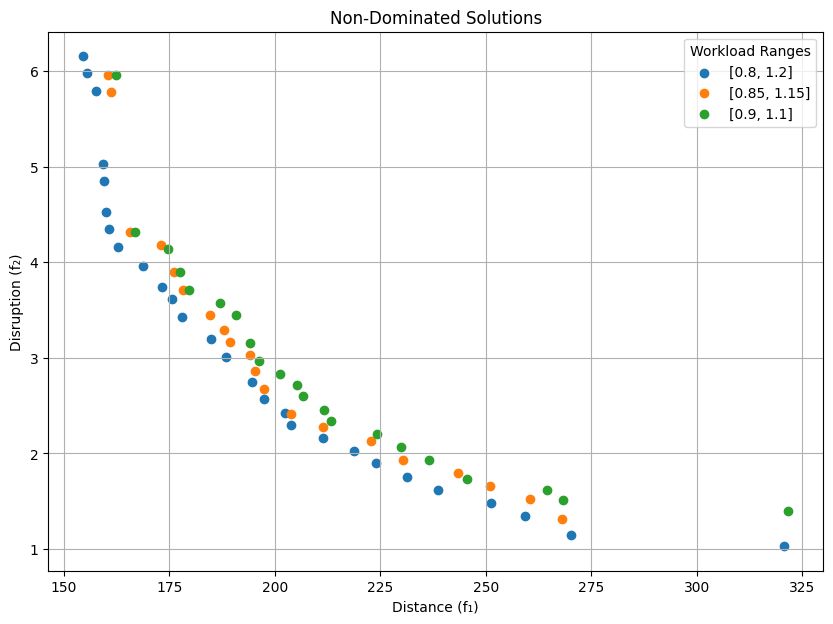

In [20]:
plot_decision_space(all_results, plot_title="Non-Dominated Solutions")

## Step2

### Scalability
To test the scalability of our optimization model, we choose to solve the minimization problem with a bigger instance, namely 100 bricks and 10 SRs. 

We first load the corresponding data.

In [21]:
distances_100, workloads_100, current_assignment_100, brick_locations_100 = load_data_100_10()

In [22]:
bricks_100 = range(100)
SRs_100 = range(10)

We use the same optimization model, but with the new data. The below cell takes around 40s to execute, so we can conclude that our model is scalable!

In [ ]:
all_results_100 = {}
delta_epsilon = 0.1

for workload_min, workload_max in workload_ranges:
    solutions = []
    epsilon = np.inf  # Start with epsilon as infinity
    
    while True:
        distance, disruption, assignment = solve_epsilon_constraint_binary(epsilon=epsilon, 
                                                                           workload_min=workload_min, 
                                                                           workload_max=workload_max,
                                                                           workloads=workloads_100,
                                                                           distances=distances_100,
                                                                           current_assignment=current_assignment_100,
                                                                           bricks=bricks_100,
                                                                           SRs=SRs_100)
        if distance is not None:
            solutions.append((epsilon, distance, disruption, assignment))
            epsilon = disruption - delta_epsilon
        else:
            break

    non_dominated_solutions = filter_non_dominated(solutions)
    all_results_100[(workload_min, workload_max)] = non_dominated_solutions

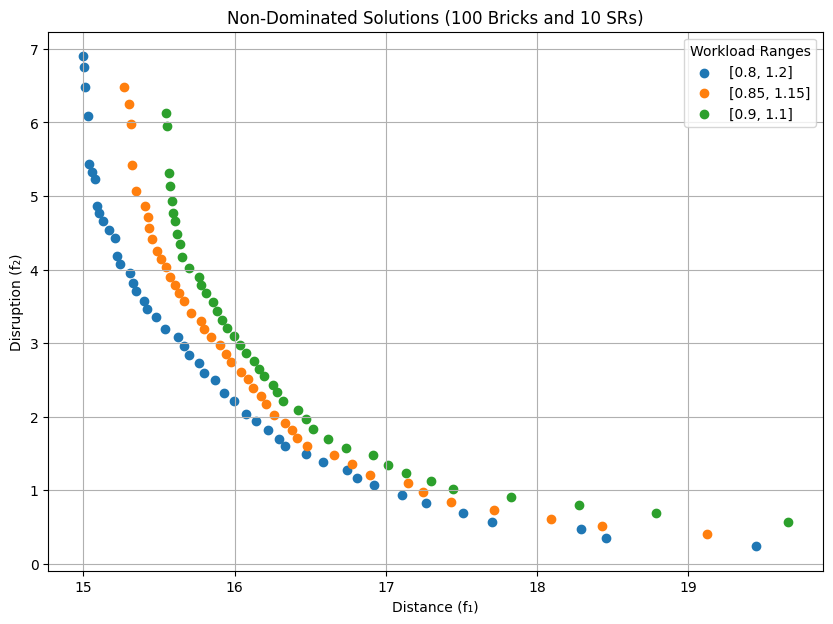

In [24]:
plot_decision_space(all_results_100, plot_title="Non-Dominated Solutions (100 Bricks and 10 SRs)")

### Partal Assignment of bricks

Instead of assigning a brick to one SR, we can relax this constraint and accept the sharing of bricks between SRs. To model that, $x_{ij}$ will no longer be binary but rather continuous.

Another important modificationin the previous code would be to change the disruption formula as we no longer have $(x_{ij} - c_{ij})^2$ = $|x_{ij} - c_{ij}|$. We need to use an additional variable $h_{ij}$ to model the absolute value $|x_{ij} - c_{ij}|$.

A trick would be to add the following constraints
$$
h_{ij} \geqslant x_{ij} - c_{ij}  \text{  and  }  h_{ij} \geqslant -(x_{ij} - c_{ij})
$$

In [25]:
def solve_epsilon_constraint_partial(epsilon, workload_min, workload_max, workloads, distances, current_assignment, bricks, SRs):
    
    model = Model("Epsilon-Constraint-Partial")
    
    # Variables
    x = model.addVars(len(bricks), len(SRs), vtype=GRB.CONTINUOUS, lb=0, ub=1, name="x")
    h = model.addVars(len(bricks), len(SRs), vtype=GRB.CONTINUOUS, name="h")

    
    # Objective Function
    distance = quicksum(distances[i, j] * x[i, j] 
                        for i in bricks for j in SRs)
    model.setObjective(distance, GRB.MINIMIZE)

    # Constraints
    # Each brick is assigned 100%
    for i in bricks:
        model.addConstr(quicksum(x[i, j] for j in SRs) == 1)
    # Workload constraints for each SR
    for j in SRs:
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) >= workload_min)
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) <= workload_max)
    # Absolute value trick
    for i in bricks:
        for j in SRs:
            model.addConstr(h[i, j] >= x[i, j] - current_assignment[i, j])
            model.addConstr(h[i, j] >= -(x[i, j] - current_assignment[i, j]))

    # Disruption constraint (sum of weighted absolute differences)
    disruption = quicksum(workloads[i] * h[i, j] for i in bricks for j in SRs)
    model.addConstr(disruption <= epsilon)
    
    # Optimization
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        return model.objVal, disruption.getValue(), [(i, j) for i in bricks for j in SRs if x[i, j].X > 0.5]
    return None, None, None

In [ ]:
all_results = {}
delta_epsilon = 0.1

for workload_min, workload_max in workload_ranges:
    solutions = []
    epsilon = np.inf  # Start with epsilon as infinity
    
    while True:
        distance, disruption, assignment = solve_epsilon_constraint_partial(epsilon=epsilon, 
                                                                            workload_min=workload_min, 
                                                                           workload_max=workload_max,
                                                                           workloads=workloads,
                                                                           distances=distances,
                                                                           current_assignment=current_assignment,
                                                                           bricks=bricks,
                                                                           SRs=SRs)
        if distance is not None:
            solutions.append((epsilon, distance, disruption, assignment))
            epsilon = disruption - delta_epsilon
        else:
            break

    non_dominated_solutions = filter_non_dominated(solutions)
    all_results[(workload_min, workload_max)] = non_dominated_solutions

In the plot of the non dominated solutions, we clearly see the expected linear shape.

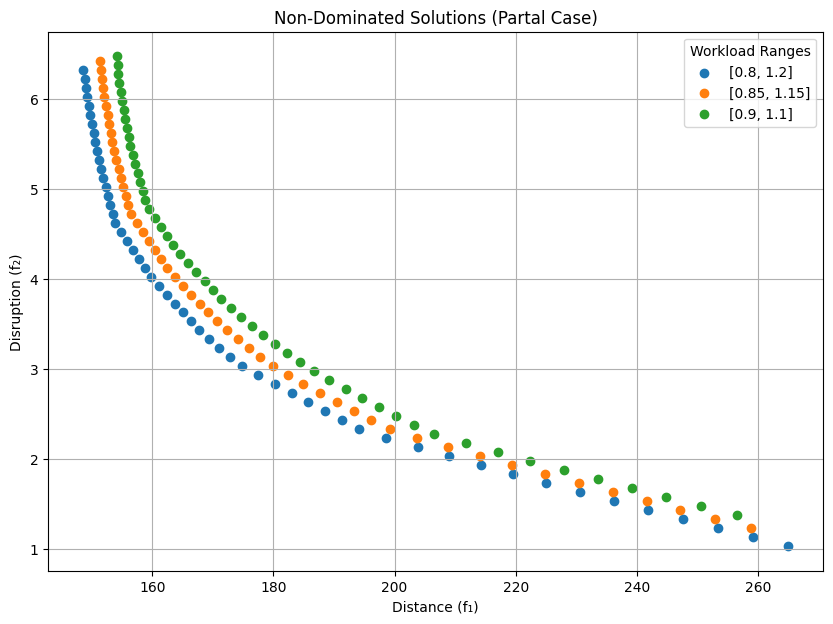

In [27]:
plot_decision_space(all_results, plot_title="Non-Dominated Solutions (Partal Case)")

### New SR

In this section, we suppose that the demand has increased uniformly in all bricks (+25%). As we result, we need to hire a new SR and chose an optimal office to this new SR.

The new office is a center of a brick that is not occupied by any SR. That means two SRs cannot have their offices in the same bricks, so we have 18 possible offices left for the new SR.

To solve this location problem, we can solve our epsilon-constraint problem for each possible office among the 18 bricks and look for the best ones.

In [28]:
extended_SRs = range(5)
adjusted_workloads = {i: workloads[i] * 1.25 for i in bricks}

occupied_bricks = np.where(np.any(distances == 0, axis=1))[0].tolist()

In [29]:
def solve_epsilon_constraint_new_SR(epsilon, workload_min, workload_max, workloads, distances, current_assignment, bricks, SRs):
    
    model = Model("Epsilon-Constraint-New-SR")
        
    # Variables
    x = model.addVars(len(bricks), len(SRs), vtype=GRB.BINARY, name="x")
        
    # Objective Function
    distance = quicksum(distances[i, j] * x[i, j] 
                        for i in bricks for j in extended_SRs)
    model.setObjective(distance, GRB.MINIMIZE)

    # Constraints
    # Each brick is assigned 100%
    for i in bricks:
        model.addConstr(quicksum(x[i, j] for j in extended_SRs) == 1)
    # Workload constraints for each SR
    for j in extended_SRs:
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) >= workload_min)
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) <= workload_max)
    # Diruption constraint
    disruption = quicksum(workloads[i] * (x[i, j] - current_assignment[i, j]) * (x[i, j] - current_assignment[i, j]) 
                          for i in bricks for j in range(len(SRs)-1))
    model.addConstr(disruption <= epsilon)
    
    # Optimization
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        return model.objVal, disruption.getValue(), [(i, j) for i in bricks for j in extended_SRs if x[i, j].X > 0.5]
    return None, None, None

In [ ]:
total_results = {}
delta_epsilon = 0.1

for i in tqdm(bricks):
    if i not in occupied_bricks:
        epsilon = np.inf
        solutions = []
        extended_distances = np.column_stack((distances, np.round(bricks_distances[str(i)].to_numpy(), 2)))
        while True:
            distance, disruption, assignment = solve_epsilon_constraint_new_SR(epsilon=epsilon,
                                                                               workload_min=0.8, 
                                                                               workload_max=1.2,
                                                                               workloads=adjusted_workloads,
                                                                               distances=extended_distances,
                                                                               current_assignment=current_assignment,
                                                                               bricks=bricks,
                                                                               SRs=extended_SRs)
            if distance is not None:
                solutions.append((epsilon, distance, disruption, assignment))
                epsilon = disruption - delta_epsilon
            else:
                break

        non_dominated_solutions = filter_non_dominated(solutions)
        total_results[str(i)] = non_dominated_solutions

We can visualise the results and see that not all bricks provide optimal solutions. For example, the choice of the SR's office is in **brick 3** gives us non optimal solutions, always, compared to the other possible center bricks.

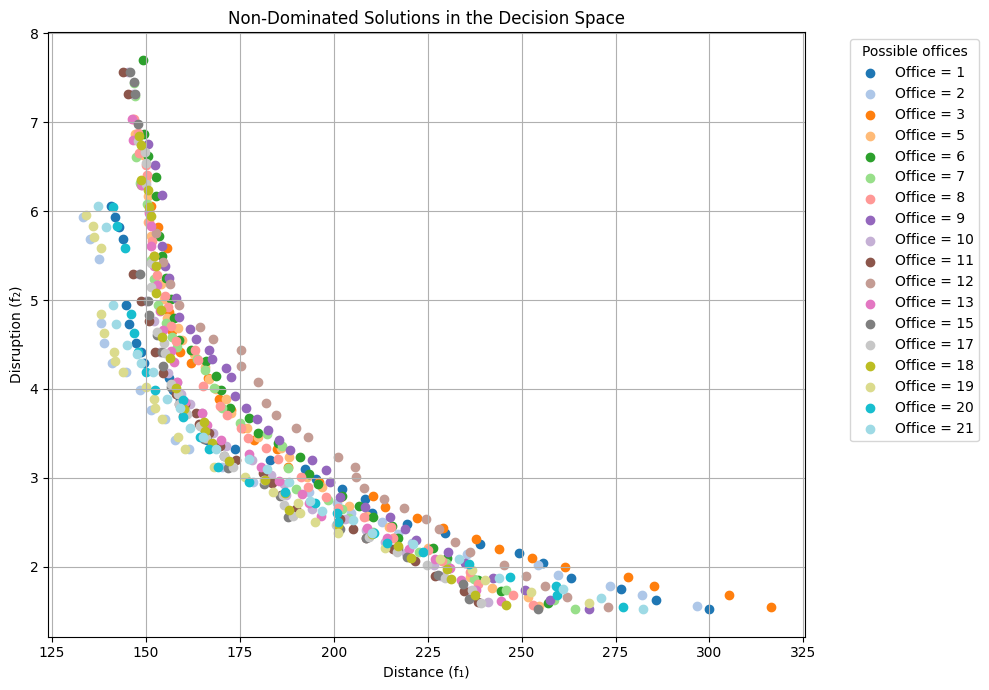

In [32]:
plot_non_dominated_across_all_offices(total_results)

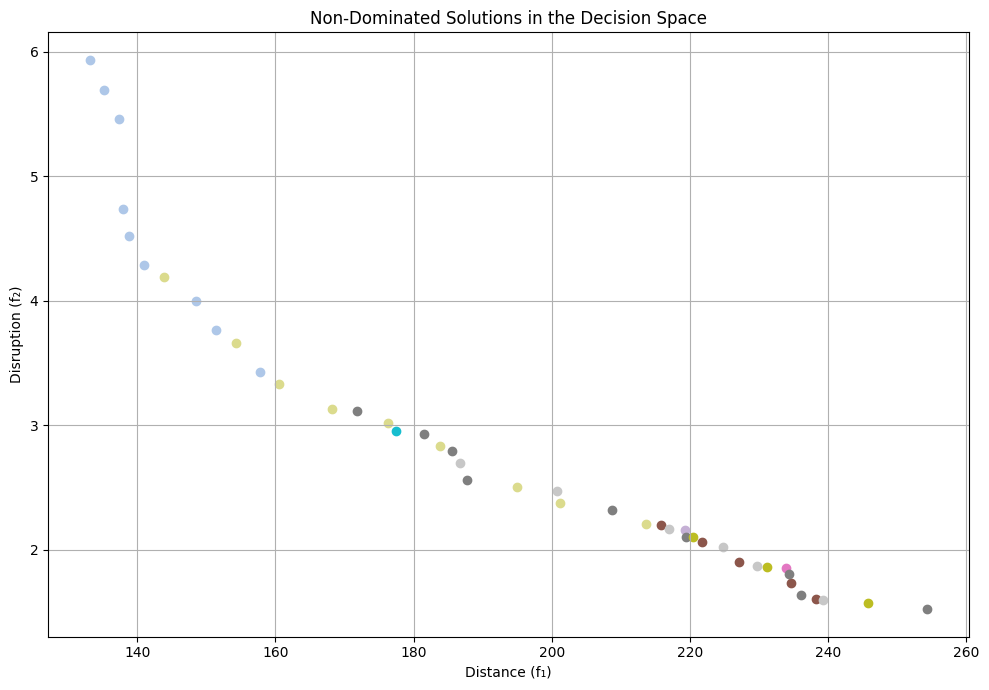

In [33]:
plot_globally_non_dominated_across_all_offices(total_results)

# Step3

In [79]:
import gurobipy as gb
import json

To run the code in this step, load in your Gurobi license info (paste it into a config.json file). Otherwise, the code below won't run at all because of license limitations.

In [ ]:
with open('config.json', 'r') as config_file:
    options = json.load(config_file)
    
grb_env = gb.Env(params=options)

We work with the 4 Sales Reps, 22 Bricks data here but given some changes here to load in the data for the "Pfitzer 10,100" the code below works.

In [42]:
N = 4
M = 22

In [21]:
brick_indices = pd.read_csv('./data/bricks_index_values.csv')
distances_df = pd.read_excel('./data/distances.xlsx', sheet_name='brick-brick', usecols="C:X", skiprows=1)

In [ ]:
distances_df.head()

In [50]:
sr_center_initial = np.zeros((N, M))
sr_center_initial[0,3] = 1
sr_center_initial[1,13] = 1
sr_center_initial[2,15] = 1
sr_center_initial[3,21] = 1

distances = np.array(distances_df.values.tolist())
workloads = np.array([brick_indices["index_value"].iloc[i] for i in range(22)])

## Biobjective model

In this first scenario, the positions of the center bricks are variable and we try to optimize for the distance and workload

In [29]:
def solve_epsilon(epsilon_value, distance_sq, workload):
    model = gb.Model(f"BiObj_eps_{epsilon_value}",env=grb_env)

    # =============== Variables ===============
    x = model.addVars(N, M, vtype=gb.GRB.BINARY, name="x")  # Assign bricks
    c = model.addVars(N, M, vtype=gb.GRB.BINARY, name="c")  # Center bricks

    # =============== Objective 1: total distance ===============
    #    distance_objective = sum_{i in reps} sum_{k in bricks} sum_{j in bricks}
    #            [distance_sq[k,j] * x[i,j] * c[i,k]]
    distance_objective = gb.quicksum(
        distance_sq[k, j] * x[i, j] * c[i, k]
        for i in range(N)
        for k in range(M)
        for j in range(M)
    )

    # =============== Objective 2: max workload ===============
    #    For each rep i, workload_i = sum_{j} [workload[j] * x[i,j]]
    #    Then workload_objective >= workload_i for all i, and we want workload_objective <= epsilon
    workload_per_SR = [gb.quicksum(workload[j] * x[i, j] for j in range(M)) for i in range(N)]
    workload_objective = model.addVar(vtype=gb.GRB.CONTINUOUS, name="MaxWorkload")
    for i in range(N):
        model.addConstr(workload_per_SR[i] <= workload_objective, name=f"MaxWork_{i}")

    # =============== Constraints ===============
    # 1) Each brick assigned to exactly one rep
    for j in range(M):
        model.addConstr(gb.quicksum(x[i, j] for i in range(N)) == 1, name=f"Assign_{j}")

    # 2) Exactly one center per SR
    for i in range(N):
        model.addConstr(gb.quicksum(c[i, k] for k in range(M)) == 1, name=f"OneCenter_{i}")

    # 3) Workload bounds
    for i in range(N):
        model.addConstr(workload_per_SR[i] >= 0.8, name=f"WorkloadMin_{i}")
        model.addConstr(workload_per_SR[i] <= 1.2, name=f"WorkloadMax_{i}")

    # =============== Epsilon constraint ===============
    model.addConstr(workload_objective <= epsilon_value, name="EpsilonConstraint")

    # =============== Solve ===============
    model.setObjective(distance_objective, gb.GRB.MINIMIZE)
    model.optimize()

    # =============== Extract solution ===============
    if model.status == gb.GRB.OPTIMAL:
        best_distance = distance_objective.getValue()
        best_workload = workload_objective.X
        assignments = model.getAttr("x", x)
        centers = model.getAttr("x", c)

        return {
            "best_distance": best_distance,
            "best_workload": best_workload,
            "assignments": assignments,
            "centers": centers,
            "model": model
        }
    else:
        return None


In [30]:
def epsilon_solve(distance_sq, workload):
    epsilon = float('inf')
    non_dominant_solutions = []

    while True:
        # Solve for the current epsilon
        result = solve_epsilon(epsilon, distance_sq, workload)
        if not result:
            # If infeasible or unbounded, break
            break

        # We have a feasible solution with distance_objective, workload_objective
        best_distance = result["best_distance"]
        best_workload = result["best_workload"]
        print(f"Epsilon={epsilon}: Found solution best_distance={best_distance}, best_workload={best_workload}")

        # Save the solution
        non_dominant_solutions.append(result)

        # Update epsilon to be just under the newly found workload_objective
        # so that in the next iteration we force a lower workload_objective (if possible)
        new_epsilon = best_workload - 0.01 # todo step var
        if new_epsilon < 0:
            # Nothing smaller is feasible
            break
        epsilon = new_epsilon

    return non_dominant_solutions


In [ ]:
solutions = epsilon_solve(distances, workloads)
for sol in solutions:
    print(f"Best Distance = {sol['best_distance']}, Best Workload = {sol['best_workload']}")

Plotting results

In [51]:
def plot_biobj_results(solutions):
    # Gather data for distance vs. workload from all solutions
    distances = [sol['best_distance'] for sol in solutions]
    workloads = [sol['best_workload'] for sol in solutions]

    plt.figure(figsize=(6, 4))
    plt.scatter(distances, workloads, marker='o', color='b')
    plt.title("Trade-off Curve: Distance vs. Workload")
    plt.xlabel("Total Distance (Objective 1)")
    plt.ylabel("Max Workload (Objective 2)")
    plt.grid(True)
    plt.show()

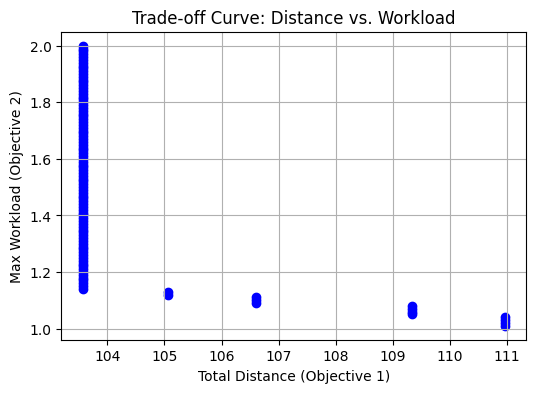

In [52]:
plot_biobj_results(solutions)

## Tri-objective Problem

In [53]:

def solve_triobjective_fixed(total_relocated_offices, epsilon_value):
    """
    Solve the tri-objective problem for:
        - EXACT number of relocated offices = total_relocated_offices
        - MAX WORKLOAD <= epsilon_value
        - MINIMIZE total distance

    Returns a dict with keys:
        'distance'       : objective1 solution 
        'max_workload'   : objective2 solution 
        'relocated_offices': objective3 solution 
        'assignments'    : x[i,j] solution
        'centers'        : c[i,j] solution
    Or None if infeasible.
    """
    model = gb.Model(f"triobj_disrupt_{total_relocated_offices}_eps_{epsilon_value}")
    
    # Decision variables
    x = model.addVars(N, M, vtype=gb.GRB.BINARY, name="x")  # Assign bricks
    c = model.addVars(N, M, vtype=gb.GRB.BINARY, name="c")  # Center bricks
    
    # y[i] = 1 if SR i has relocated its office, 0 otherwise
    y = model.addVars(N, vtype=gb.GRB.BINARY, name="y")

    # ---- 1) Objective 1: total distance ----
    # distance = sum_{i in SR} sum_{k in bricks} sum_{j in bricks}
    #                 distance_sq[k,j] * x[i,j] * c[i,k]
    # We'll store it in a Gurobi expression to set as objective
    distance_expr = gb.quicksum(
        distances[k, j] * x[i, j] * c[i, k]
        for i in range(N)
        for k in range(M)
        for j in range(M)
    )

    # ---- 2) Objective 2: maximum workload ----
    # workload_i = sum_{j} [workloads[j] * x[i,j]] for i in SR
    # workload_obj = max over i of workload_i
    # We handle via an ep-constraint approach: workload_obj <= epsilon_value
    workload_exprs = [gb.quicksum(workloads[j] * x[i, j] for j in range(M)) for i in range(N)]
    max_workload_var = model.addVar(vtype=gb.GRB.CONTINUOUS, name="MaxWorkload")
    
    # Constrain each workload_i <= max_workload_var
    for i in range(N):
        model.addConstr(workload_exprs[i] <= max_workload_var, name=f"WorkloadLink_{i}")

    # ---- 3) Objective 3: number of relocated offices ----
    # distruption_objective = sum_i y[i], forcibly set to "total_relocated_offices"
    # That means we fix the total number of relocated offices to a specific integer
    disruption_expr = gb.quicksum(y[i] for i in range(N))
    model.addConstr(disruption_expr == total_relocated_offices, name="FixedRelocatedOffices")

    # We link y[i] to whether center i is changed:
    for i in range(N):
        for j in range(M):
            # If c[i,j] differs from sr_center_initial[i][j], then y[i] = 1
            # Implementing constraints: y[i] >= c[i,j] - sr_center_initial[i][j]
            #                            y[i] >= sr_center_initial[i][j] - c[i,j]
            # The difference c[i,j] - sr_center_initial[i,j] can be -1,0, or 1
            model.addConstr(y[i] >= c[i, j] - sr_center_initial[i][j], name=f"RelocPos_{i}_{j}")
            model.addConstr(y[i] >= sr_center_initial[i][j] - c[i, j], name=f"RelocNeg_{i}_{j}")

    # ---- Additional constraints ----
    # 1) Each brick assigned to exactly 1 rep
    for j in range(M):
        model.addConstr(gb.quicksum(x[i, j] for i in range(N)) == 1, name=f"OneRepPerBrick_{j}")

    # 2) Exactly 1 center brick per SR
    for i in range(N):
        model.addConstr(gb.quicksum(c[i, k] for k in range(M)) == 1, name=f"OneCenterPerSR_{i}")

    # 3) Workload bounds (0.8 <= workload <= 1.2)
    for i in range(N):
        model.addConstr(workload_exprs[i] >= 0.8, name=f"MinWorkload_{i}")
        model.addConstr(workload_exprs[i] <= 1.2, name=f"MaxWorkload_{i}")

    # ---- \epsilon-constraint on workload_obj ----
    model.addConstr(max_workload_var <= epsilon_value, name="EpsConstraint_Workload")

    # ---- Set objective to minimize total distance ----
    model.setObjective(distance_expr, gb.GRB.MINIMIZE)

    # Solve
    model.optimize()

    # If optimal solution found, collect it
    if model.status == gb.GRB.OPTIMAL:
        sol_distance = distance_expr.getValue()              # distance_objective
        sol_maxworkload = max_workload_var.X                 # workload_objective
        sol_disruption = total_relocated_offices             # distruption_objective

        # Extract assignment & centers
        x_sol = np.array([[x[i, j].X for j in range(M)] for i in range(N)])
        c_sol = np.array([[c[i, j].X for j in range(M)] for i in range(N)])

        return {
            'distance': sol_distance,
            'max_workload': sol_maxworkload,
            'relocated_offices': sol_disruption,
            'assignments': x_sol,
            'centers': c_sol
        }

    return None  # Infeasible or unbounded

In [54]:

def triobjective_solutions(distances, workloads, sr_center_initial):
    """
    Collect solutions across all possible relocated_offices = 0..N
    For each, do an epsilon-constraint loop over max workload .
    Return a list of all feasible (dist, workload, disrupt) solutions plus assignments.
    """

    solutions = []
    # For each possible integer from 0 to N
    for relocated_offices_count in range(N + 1):
        # We'll start from a large epsilon, 
        # move downward each time we find a feasible solution (the same approach as your biobj code).
        epsilon = float('inf')
        while True:
            result = solve_triobjective_fixed(
                total_relocated_offices=relocated_offices_count,
                epsilon_value=epsilon
            )
            if result is None:
                # No feasible solution for epsilon -> break from that loop
                break            
            solutions.append(result)

            # Update epsilon to be just below the best max_workload found
            new_eps = result['max_workload'] - 0.01
            if new_eps < 0:
                break
            epsilon = new_eps

    return solutions

Actually compute the tri-objective solution

In [ ]:
tri_solutions = triobjective_solutions(distances, workloads, sr_center_initial)

print(f"Number of solutions found: {len(tri_solutions)}")
for sol in tri_solutions:
    print(f"Distance={sol['distance']:.3f}, "
          f"Max Workload={sol['max_workload']:.3f}, "
          f"Relocations={sol['relocated_offices']}")

In [58]:
def plot_triobjective_solutions(solutions):
    """
    Plot the solution set in 3D: X=distance, Y=max_workload, Z=relocated_offices
    """
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    obj1_vals = [sol['distance'] for sol in solutions]
    obj2_vals = [sol['max_workload'] for sol in solutions]
    obj3_vals = [sol['relocated_offices'] for sol in solutions]

    sc = ax.scatter(obj1_vals, obj2_vals, obj3_vals, c=obj3_vals, cmap='viridis', s=50)

    ax.set_xlabel('Total Distance')
    ax.set_ylabel('Max Workload')
    ax.set_zlabel('Relocated Offices')
    plt.title('Tri-objective Solutions')
    plt.colorbar(sc, label='Relocated Offices')
    plt.show()


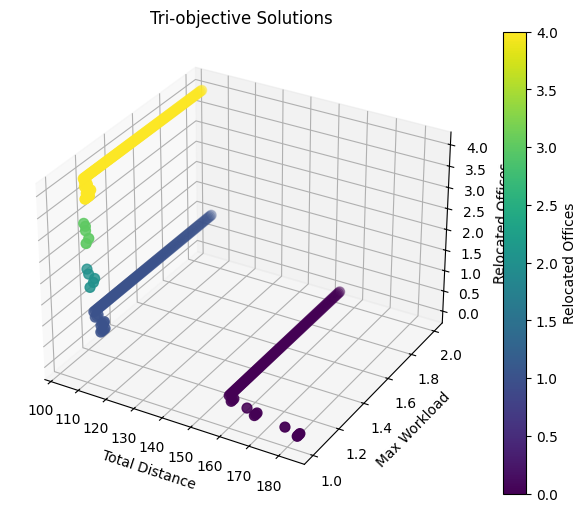

In [59]:
plot_triobjective_solutions(tri_solutions)

Filtering for non dominated solutions

In [65]:
def is_dominated(s1, s2):
    """
    Returns True if solution s1 is dominated by solution s2
    for the three objectives (distance, max_workload, relocated_offices).
    s1 is dominated if s2 is strictly better or equal on all objectives 
    and strictly better on at least one objective.
    
    For a minimization problem, "better or equal" means 
      s2[obj] <= s1[obj]
    and "strictly better on at least one" means 
      s2[obj] < s1[obj] for some obj.
    """
    better_or_equal = (
        (s2['distance'] <= s1['distance']) and
        (s2['max_workload'] <= s1['max_workload']) and
        (s2['relocated_offices'] <= s1['relocated_offices'])
    )
    strictly_better_one = (
        (s2['distance'] < s1['distance']) or
        (s2['max_workload'] < s1['max_workload']) or
        (s2['relocated_offices'] < s1['relocated_offices'])
    )
    return better_or_equal and strictly_better_one

def filter_pareto_nondominated(solutions):
    non_dom = []
    for s in solutions:
        # check if s is dominated by any solution in the set
        dominated = any(is_dominated(s, other) for other in solutions if other != s)
        if not dominated:
            non_dom.append(s)
    return non_dom

In [66]:
tri_solutions_nd = filter_pareto_nondominated(tri_solutions)
print(f"Non-dominated solutions found: {len(tri_solutions_nd)} out of {len(tri_solutions)} total.")

Non-dominated solutions found: 29 out of 310 total.


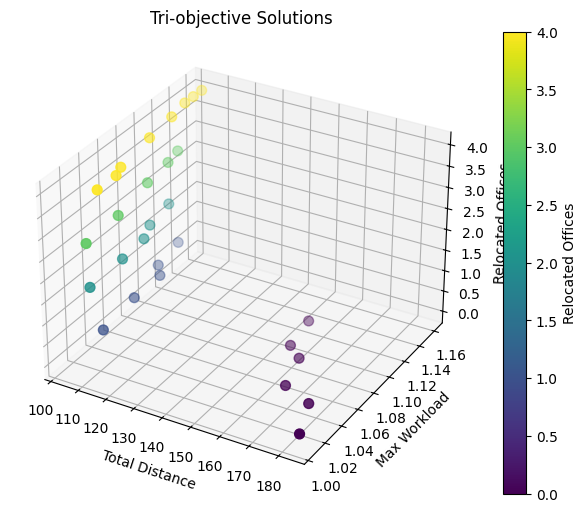

In [67]:
plot_triobjective_solutions(tri_solutions_nd)

In [71]:
def export_solutions_to_csv(solutions, filename="triobjective_solutions.csv"):
    """
    Convert the list of solution dictionaries to a DataFrame and export to CSV.
    """
    out_rows = []
    for idx, sol in enumerate(solutions):
        row = {
            "solution_id": idx,
            "distance": sol['distance'],
            "max_workload": sol['max_workload'],
            "relocated_offices": sol['relocated_offices'],
        }
        out_rows.append(row)

    df = pd.DataFrame(out_rows)
    df.to_csv(filename, index=False)
    print(f"Exported {len(df)} solutions to {filename}")


In [76]:
export_solutions_to_csv(tri_solutions, filename="./data/triobjective_solutions.csv")


Exported 310 solutions to ./data/triobjective_solutions.csv


In [77]:
export_solutions_to_csv(tri_solutions_nd, filename="./data/triobjective_nondominated_solutions.csv")


Exported 29 solutions to ./data/triobjective_nondominated_solutions.csv


# Step4

In [17]:
preferences_data = pd.read_excel('data/Preferences.xlsx', sheet_name='DM Preferences')

In [18]:
criteria_values = preferences_data[['distance', 'max_workload', '#changed offices']].values
rankings = preferences_data['rank'].values

In [19]:
print(criteria_values)

[[ 83.7222536    1.06635769   1.        ]
 [ 86.06487029   1.12324265   0.        ]
 [ 89.6639451    1.11419638   1.        ]
 [ 80.18637567   1.22684437   1.        ]
 [ 79.22761378   1.18049994   2.        ]
 [ 75.21489302   1.40483011   0.        ]
 [ 83.30801015   1.47108284   0.        ]
 [ 82.39731414   1.40964798   1.        ]
 [ 81.46646041   1.02921185   4.        ]
 [ 91.78442093   1.08713063   3.        ]
 [103.31869586   1.22381242   0.        ]
 [ 94.12387853   1.30654991   0.        ]
 [117.85792847   1.03242009   2.        ]
 [ 88.98791323   1.26218968   2.        ]
 [ 76.43830663   1.29014786   3.        ]
 [185.90059899   1.10404998   1.        ]
 [ 91.24773431   1.40160377   2.        ]
 [101.50924779   1.18227143   3.        ]
 [118.22552192   1.26511839   1.        ]
 [110.22721834   1.3274603    1.        ]
 [139.69758501   1.03614225   3.        ]
 [129.53077717   1.17472727   2.        ]
 [129.11889303   1.18579896   2.        ]
 [116.87062859   1.17204803   3.  

In [20]:
print(rankings)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


Pairwise Ranking Set:

$$ P = \{ (r_i, r_j) \mid i < j \} $$

where $i < j$ ensures that only pairs where $i$ is ranked better than $j$ are included.  

In [21]:
rank_indices = [rank - 1 for rank in rankings]
pairwise_rankings = [(rank_indices[i], rank_indices[j]) for i in range(len(rank_indices)) for j in range(i + 1, len(rank_indices))]

In [22]:
non_dominated_solutions_df = pd.read_csv("data/triobjective_nondominated_solutions.csv")

In [23]:
non_dominated_solutions_df.head()

,solution_id,distance,max_workload,relocated_offices
0,0,154.615221,1.12,0
1,1,156.707324,1.09,0
2,2,162.630563,1.08,0
3,3,166.533555,1.05,0
4,4,177.377370,1.04,0


In [24]:
non_dominated_solutions = non_dominated_solutions_df.iloc[:, 1:].values

In [25]:
non_dominated_solutions.shape

(29, 3)

## UTA

### Adaptation of the TD Approach to the Project

In the TD, we learned a method to infer piecewise linear utility functions for ranking alternatives based on multiple criteria. In this step, we apply this approach to rank the **non-dominated solutions** identified in our project. 

#### Notation:
- $i$: Criterion  
- $j$: Alternative (non-dominated solution)
- $k$: Breakpoint in the piecewise linear utility function  
- $u$: Utility score  

Each criterion $i$ has a range $[\text{min}_i, \text{max}_i]$ divided into $L_i$ subintervals, where breakpoints $x_i^k$ define the utility function.

#### Considered Criteria:
- **Total Distance**
- **Max Workload**
- **Number of Relocated Offices**

#### Utility Function:

Breakpoints for each criterion are defined as:

$$
x_i^k = \text{min}_i + \frac{k}{L_i} (\text{max}_i - \text{min}_i).
$$

For a value $x_{i,j}$ within the interval $[x_i^k, x_i^{k+1}]$, the utility function is interpolated as:

$$
u_i(x_{i,j}) = u_i(x_i^k) + \frac{x_{i,j} - x_i^k}{x_i^{k+1} - x_i^k} (u_i(x_i^{k+1}) - u_i(x_i^k)).
$$


In [26]:
def calculate_solution_u(solution, piecewise_u, breakpoints, n_criteria):
    total_u = 0
    for i in range(n_criteria):
        for j in range(len(breakpoints[i]) - 1):
            if breakpoints[i][j] <= solution[i] < breakpoints[i][j + 1]:
                slope = (piecewise_u[i][j + 1] - piecewise_u[i][j]) / (
                    breakpoints[i][j + 1] - breakpoints[i][j]
                )
                total_u += piecewise_u[i][j] + slope * (solution[i] - breakpoints[i][j])
    return total_u

To construct the utility functions, the UTA method minimizes the sum of two error terms, $\sigma_j^+$ and $\sigma_j^-$, which represent the **overestimation and underestimation errors** associated with each non-dominated solution $j$. These errors ensure that the inferred utility values are as consistent as possible with the given rankings.

In this project, the ranking information available is a **strict ranking** of the non-dominated solutions.

The UTA method is based on minimizing the sum of error terms:

$$
z = \min \sum_j (\sigma_j^+ + \sigma_j^-)
$$

subject to the following constraints:

1. **Strict ranking condition**:  
   Ensures that if solution $j$ is ranked higher than solution $j'$, its total utility must be strictly greater:

$$
\sum_i u_i(x_{i,j}) - \sigma_j^+ + \sigma_j^- \geqslant \sum_i u_i(x_{i,j'}) - \sigma_{j'}^+ + \sigma_{j'}^- + \varepsilon, \quad \text{if } j \succ j'
$$

2. **Piecewise monotonicity of the utility function**:  
   Ensures that the utility function for each criterion is **non-decreasing**:

$$
u_i(x_i^{k+1}) - u_i(x_i^k) \geqslant \varepsilon, \quad \forall i, k = 0 \dots L_i - 1.
$$

3. **Normalization constraints**:  
   The utility scale is standardized, ensuring all utilities sum to 1:

$$
u_i(x_i^0) = 0, \quad \forall i,
$$

$$
\sum_i u_i(x_i^{L_i}) = 1.
$$


In [27]:
n_criteria = non_dominated_solutions.shape[1]
n_alternatives = len(criteria_values)
epsilon_mono = 1e-4
epsilon_rank = 1e-4
L_max = 10
breakpoints = {i: np.linspace(min(criteria_values[:, i]), max(criteria_values[:, i]), L_max) for i in range(n_criteria)}

In [28]:
model = Model("UTA")

u = {i: model.addVars(n_alternatives, lb = 0, ub= 1/n_criteria, name = f"u_{i}") for i in range(n_criteria)}
sigma_plus = model.addVars(n_alternatives, lb = 0, name="sigma_plus")
sigma_minus = model.addVars(n_alternatives, lb = 0, name="sigma_minus")

# Normalization and piecewise monotonicity constraints
for i in range(n_criteria):
    model.addConstr(u[i][0] == 0, name=f"u_min_{i}")
    model.addConstr(u[i][n_alternatives - 1] == 1/n_criteria, name=f"u_max_{i}")
    for k in range(n_alternatives - 1):
        model.addConstr(u[i][k + 1] - u[i][k] >= epsilon_mono, name=f"Piecewise_{i}_{k}")  # ensures monotonicity

# Strict ranking constraints
for better, worse in pairwise_rankings:
    better_u = quicksum(
        u[i][j] * (criteria_values[better, i] - breakpoints[i][j])
        for i in range(n_criteria)
        for j in range(len(breakpoints[i]) - 1)
        if breakpoints[i][j] <= criteria_values[better, i] < breakpoints[i][j + 1]
    )
    worse_u = quicksum(
        u[i][j] * (criteria_values[worse, i] - breakpoints[i][j])
        for i in range(n_criteria)
        for j in range(len(breakpoints[i]) - 1)
        if breakpoints[i][j] <= criteria_values[worse, i] < breakpoints[i][j + 1]
    )
    model.addConstr(
        better_u + sigma_minus[better] - sigma_plus[better]
        >= worse_u + sigma_minus[worse] - sigma_plus[worse] + epsilon_rank,
        name=f"Strict_Preference_{better}_{worse}",
    )

model.setObjective(quicksum(sigma_plus[j] + sigma_minus[j] for j in range(n_alternatives)), GRB.MINIMIZE)

model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 861 rows, 195 columns and 6661 nonzeros
Model fingerprint: 0x4e83f891
Coefficient statistics:
  Matrix range     [7e-04, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e-01, 3e-01]
  RHS range        [1e-04, 3e-01]
Presolve removed 106 rows and 102 columns
Presolve time: 0.01s
Presolved: 755 rows, 93 columns, 5919 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.050957e-01   0.000000e+00      0s
     144    9.8828071e-02   0.000000e+00   0.000000e+00      0s

Solved in 144 iterations and 0.01 seconds (0.01 work units)
Optimal objective  9.882807106e-02


After solving the UTA model, the **optimal objective function value** obtained is **0.0988**. This means that there does not exist an **exact additive value function** that can fully represent the ranking provided as input. However, since the objective function value remains relatively small (**less than 0.1**), the inferred utility functions still provide a **reasonable approximation** of the decision maker's preferences.

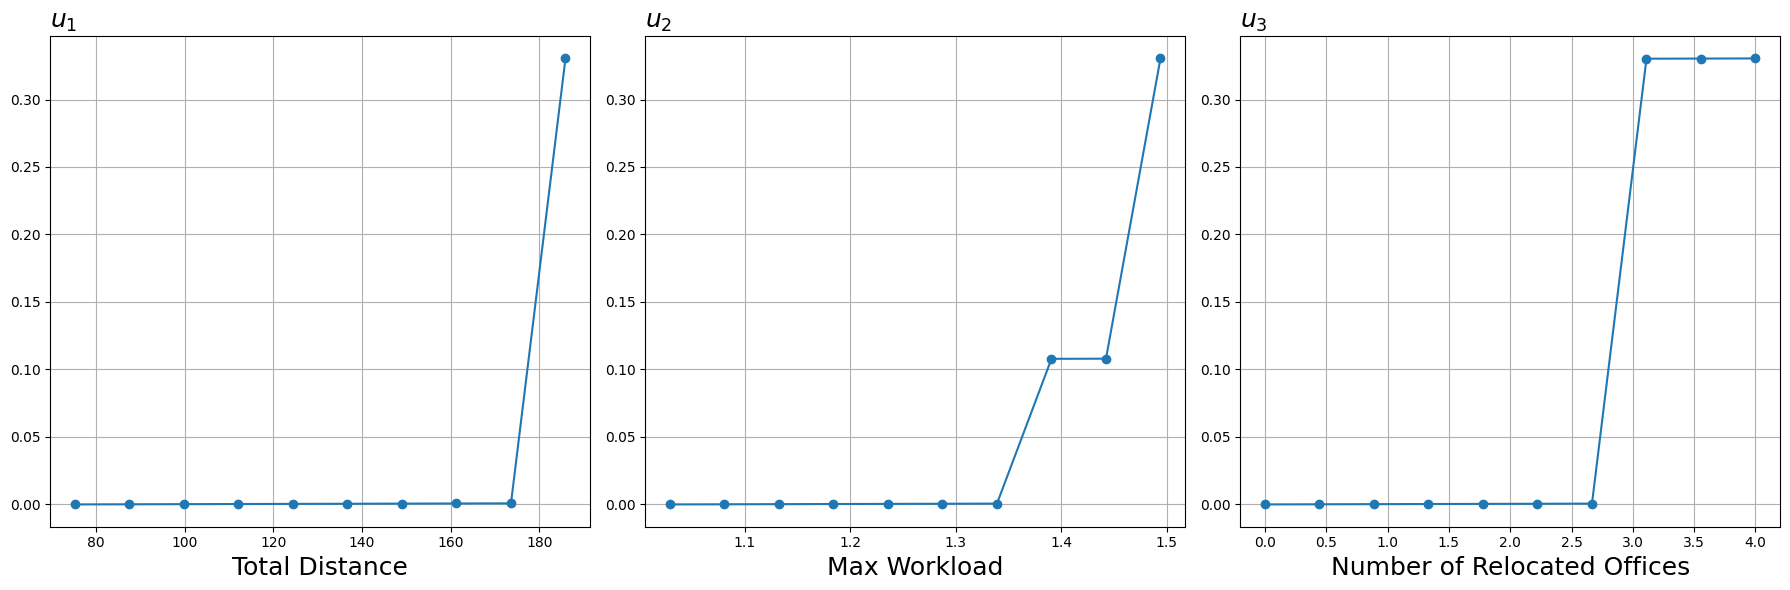

In [29]:
if model.status == GRB.OPTIMAL:
    piecewise_u = {}
    for i in range(n_criteria):
        piecewise_u[i] = [u[i][j].X for j in range(len(breakpoints[i]))]

    # Plot piecewise functions
    fig, axes = plt.subplots(1, n_criteria, figsize=(18, 6))
    for i, ax in enumerate(axes):
        ax.plot(breakpoints[i], piecewise_u[i], marker="o")
        ax.set_xlabel(["Total Distance", "Max Workload", "Number of Relocated Offices"][i], fontsize=18)
        ax.set_title(f"$u_{i+1}$", fontsize=18, loc='left')
        ax.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No optimal solution found for UTA.")


In [30]:
solution_u = [
    (solution, calculate_solution_u(solution, piecewise_u, breakpoints, n_criteria))
    for solution in non_dominated_solutions
]

print("All solutions and their utilities:")
for solution, utility in solution_u:
    print(f"Solution: {solution}, Utility: {utility:.4f}")

best_solution = max(solution_u, key=lambda x: x[1])
print(f"\nBest solution: {best_solution[0]} with utility: {best_solution[1]:.4f}")

All solutions and their utilities:
Solution: [154.61522149   1.12         0.        ], Utility: 0.0008
Solution: [156.707324   1.09       0.      ], Utility: 0.0008
Solution: [162.63056342   1.08         0.        ], Utility: 0.0008
Solution: [166.53355458   1.05         0.        ], Utility: 0.0008
Solution: [177.37736973   1.04         0.        ], Utility: 0.1020
Solution: [182.83943561   1.01         0.        ], Utility: 0.2484
Solution: [106.71323272   1.12         1.        ], Utility: 0.0007
Solution: [108.80533523   1.09         1.        ], Utility: 0.0006
Solution: [112.62476119   1.08         1.        ], Utility: 0.0006
Solution: [112.91619976   1.05         1.        ], Utility: 0.0006
Solution: [114.94458094   1.01         1.        ], Utility: 0.0005
Solution: [105.05653001   1.1149       2.        ], Utility: 0.0009
Solution: [107.14863252   1.0866       2.        ], Utility: 0.0008
Solution: [110.13089795   1.0706       2.        ], Utility: 0.0008
Solution: [111.0750

The majority of solutions have scores between **0.0005 and 0.0009**, indicating they are less preferred. A few solutions achieve high score:
  - Solutions with 3 relocated offices: e.g., `[103.63, 1.13, 3]` have a utility of **0.2483**.
  - Solutions with 0 relocated offices: e.g., `[182.84, 1.01, 0]` have the **highest utility at 0.2484**.

The best solution balances workload fairness while avoiding unnecessary office reassignments, even at the cost of a slightly higher total distance. This shows that the UTA model **prioritizes minimizing relocations while maintaining a reasonable workload balance**, even if it results in a slightly higher total distance. 